In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

### EDA

In [3]:
df = pd.read_excel("../data/raw/train_file.xlsx")

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no


In [5]:
df.shape

(32910, 15)

In [6]:
df.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
previous        int64
poutcome       object
y              object
dtype: object

In [7]:
df.isna().sum().sum()

0

#### traget encoding

In [8]:
df["y"] = df["y"].map({"no": 0, "yes": 1})

In [9]:
df["y"].value_counts()

y
0    29203
1     3707
Name: count, dtype: int64

In [10]:
df["y"].mean()  # --> disbalanced

0.11264053479185658

#### features

In [11]:
cat_feats = df.drop("y", axis=1).select_dtypes(include="object").columns.tolist()

In [12]:
int_feats = df.drop("y", axis=1).select_dtypes(exclude="object").columns.tolist()

In [13]:
cat_feats = cat_feats + ["campaign", "previous"]
int_feats = [x for x in int_feats if x not in ["campaign", "previous"]]

In [14]:
cat_feats, int_feats

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome',
  'campaign',
  'previous'],
 ['age', 'duration'])

#### int_feats

In [15]:
df.groupby("y")[int_feats].agg(["count", "median", "mean", "std"]).reset_index()

y    age                              duration                     \
      count median       mean        std    count median        mean   
0  0  29203   38.0  39.907133   9.891615    29203  164.0  221.161833   
1  1   3707   37.0  40.856757  13.755703     3707  449.0  549.662530   

               
          std  
0  208.353892  
1  397.678053

In [16]:
bins = 20

for col in int_feats:
    df[f"{col}_bins"] = pd.qcut(df[col], q=bins).astype(str)

    display(df[f"{col}_bins"].value_counts().sort_index())

age_bins
(16.999, 26.0]    1928
(26.0, 28.0]      1471
(28.0, 30.0]      2528
(30.0, 31.0]      1550
(31.0, 32.0]      1473
(32.0, 33.0]      1442
(33.0, 34.0]      1403
(34.0, 35.0]      1415
(35.0, 37.0]      2560
(37.0, 38.0]      1139
(38.0, 40.0]      2073
(40.0, 41.0]      1031
(41.0, 43.0]      1741
(43.0, 45.0]      1694
(45.0, 47.0]      1569
(47.0, 49.0]      1445
(49.0, 52.0]      1927
(52.0, 55.0]      1662
(55.0, 58.0]      1538
(58.0, 98.0]      1321
Name: count, dtype: int64

duration_bins
(-0.001, 36.0]     1663
(103.0, 117.0]     1650
(117.0, 131.0]     1637
(131.0, 146.0]     1598
(146.0, 162.0]     1641
(162.0, 180.0]     1676
(180.0, 200.0]     1664
(200.0, 221.0]     1583
(221.0, 248.0]     1663
(248.0, 280.0]     1645
(280.0, 319.0]     1616
(319.0, 369.0]     1662
(36.0, 59.0]       1670
(369.0, 438.0]     1630
(438.0, 550.0]     1646
(550.0, 750.0]     1644
(59.0, 75.0]       1668
(75.0, 89.0]       1648
(750.0, 4918.0]    1643
(89.0, 103.0]      1663
Name: count, dtype: int64

In [17]:
int_feats_bins = [x for x in df if "bins" in x]

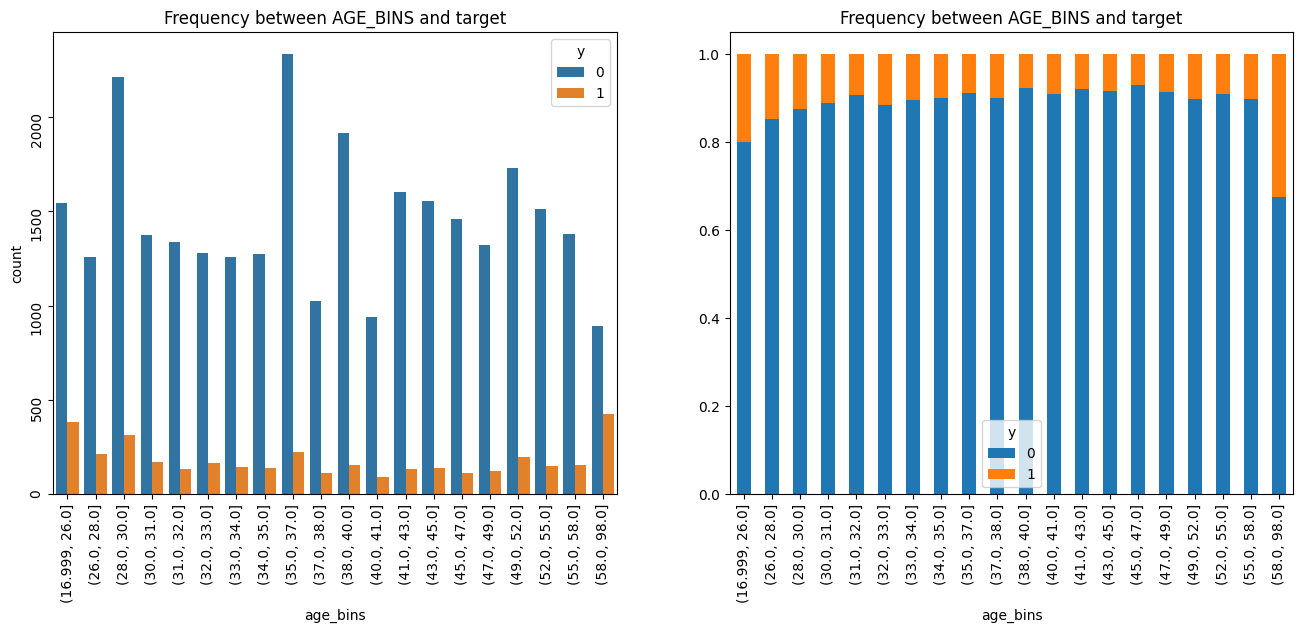

----------------------------------------------------------------------------------------------------


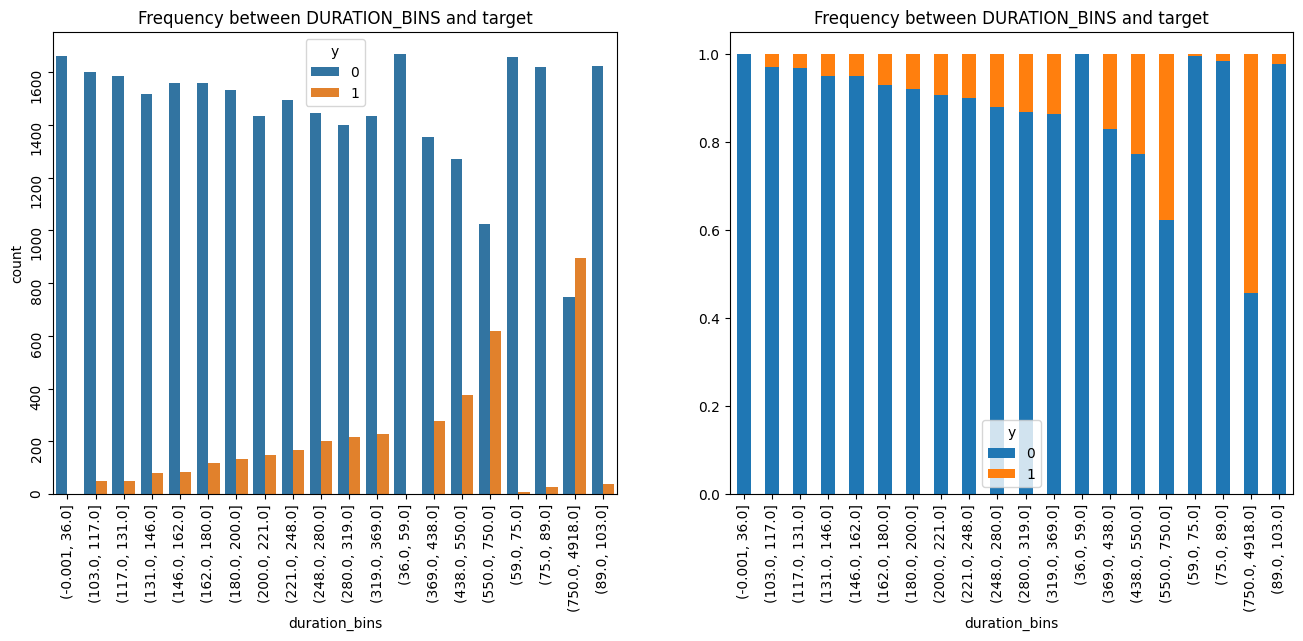

----------------------------------------------------------------------------------------------------


In [22]:
for cf in int_feats_bins:
    # display(df.groupby('job')['y'].agg(['count', 'median', 'mean', 'std']))
    df_freq = df.groupby([cf, "y"])[cf].count().reset_index(name="count")
    df_stack = df.groupby(cf)["y"].value_counts(normalize=True).unstack().fillna(0)

    figure, axis = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(data=df_freq, x=cf, hue="y", y="count", ax=axis[0])
    axis[0].tick_params(rotation=90)
    axis[0].set_title(f"Frequency between {cf.upper()} and target")

    df_stack.plot(
        kind="bar", stacked=True, color=["tab:blue", "tab:orange"], ax=axis[1]
    )
    axis[1].set_title(f"Frequency between {cf.upper()} and target")
    plt.show()

    print("-" * 100)

In [18]:
df.groupby(pd.qcut(df["age"], q=5), observed=False).agg(
    {"y": ["count", "median", "mean", "std"]}
)

y                           
               count median      mean       std
age                                            
(16.999, 31.0]  7477    0.0  0.145112  0.352237
(31.0, 35.0]    5733    0.0  0.102564  0.303415
(35.0, 41.0]    6803    0.0  0.087020  0.281886
(41.0, 49.0]    6449    0.0  0.079547  0.270612
(49.0, 98.0]    6448    0.0  0.144076  0.351194

In [19]:
df.groupby(pd.qcut(df["duration"], q=5), observed=False).agg(
    {"y": ["count", "median", "mean", "std"]}
)

y                           
                count median      mean       std
duration                                        
(-0.001, 89.0]   6649    0.0  0.005264  0.072367
(89.0, 146.0]    6548    0.0  0.033445  0.179810
(146.0, 221.0]   6564    0.0  0.073126  0.260363
(221.0, 369.0]   6586    0.0  0.122684  0.328100
(369.0, 4918.0]  6563    0.0  0.329880  0.470205

#### cat_feats

In [20]:
cat_feats;

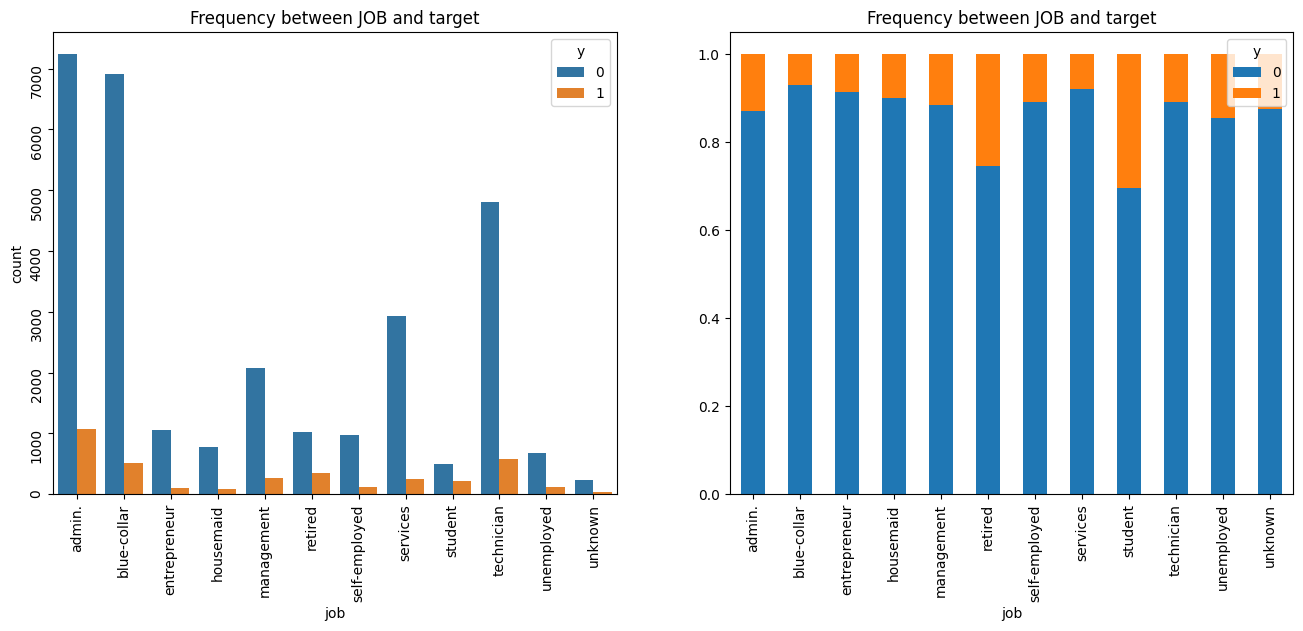

----------------------------------------------------------------------------------------------------


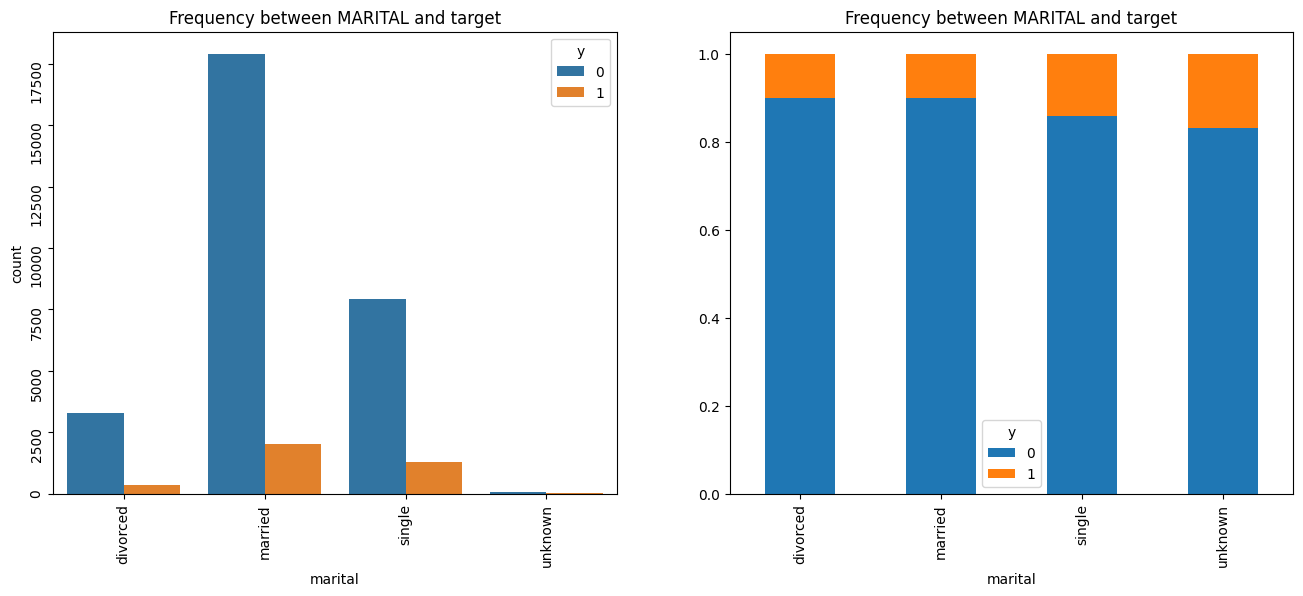

----------------------------------------------------------------------------------------------------


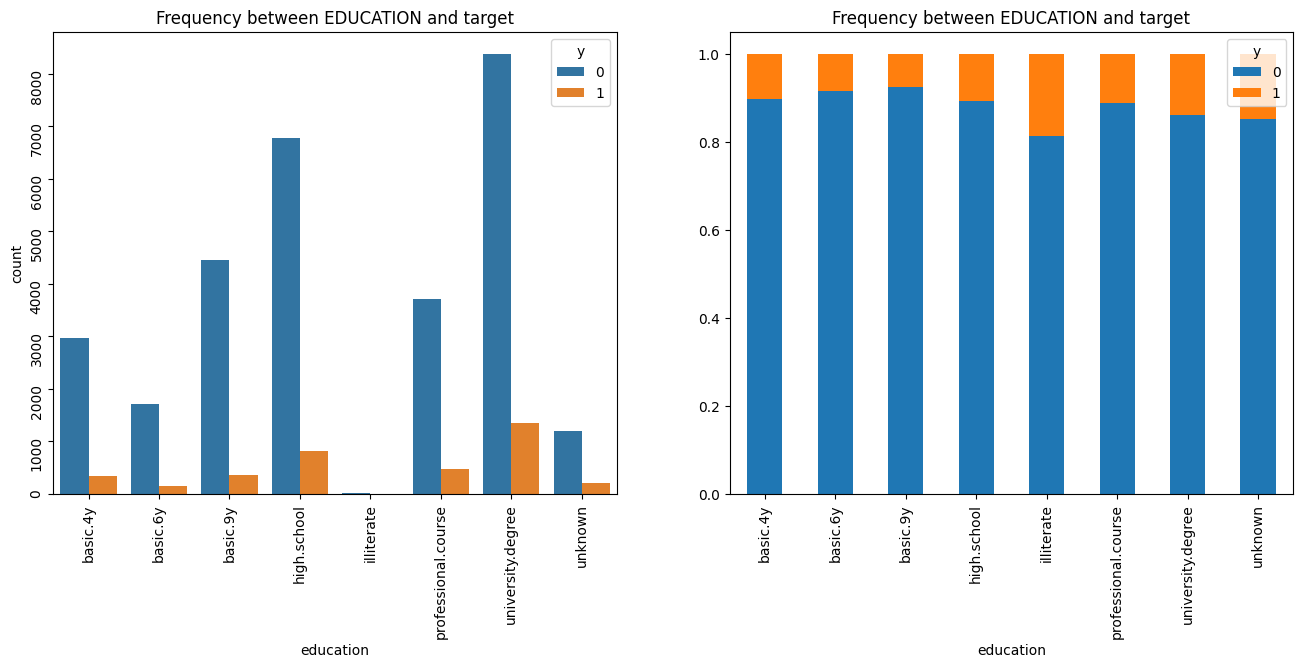

----------------------------------------------------------------------------------------------------


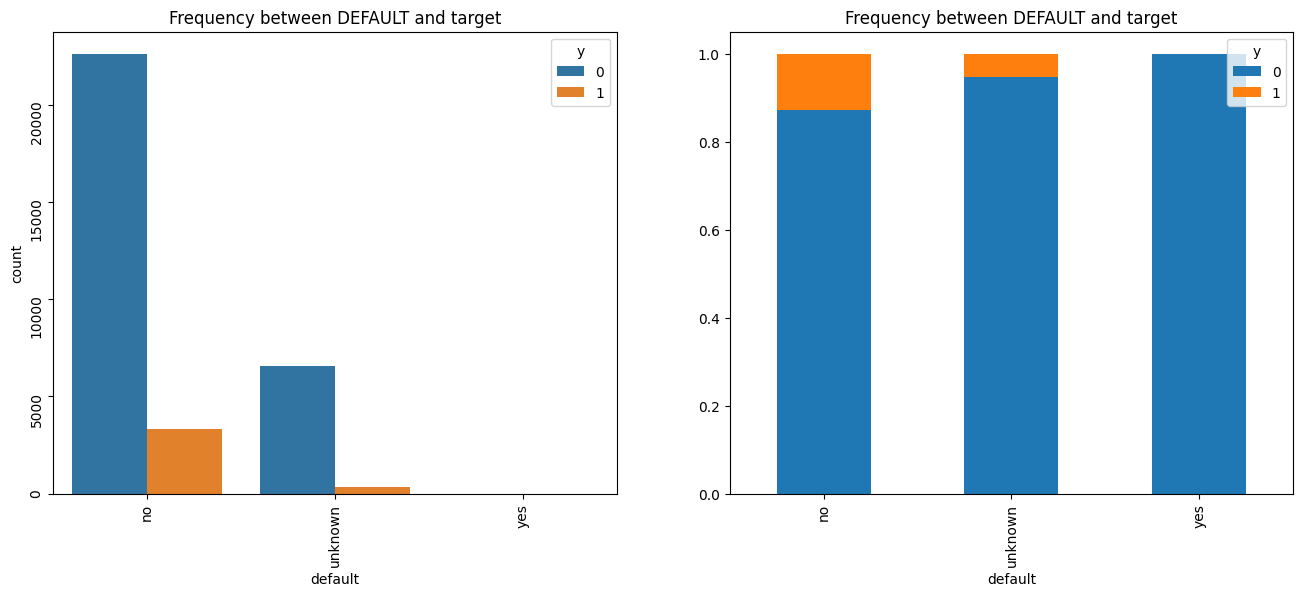

----------------------------------------------------------------------------------------------------


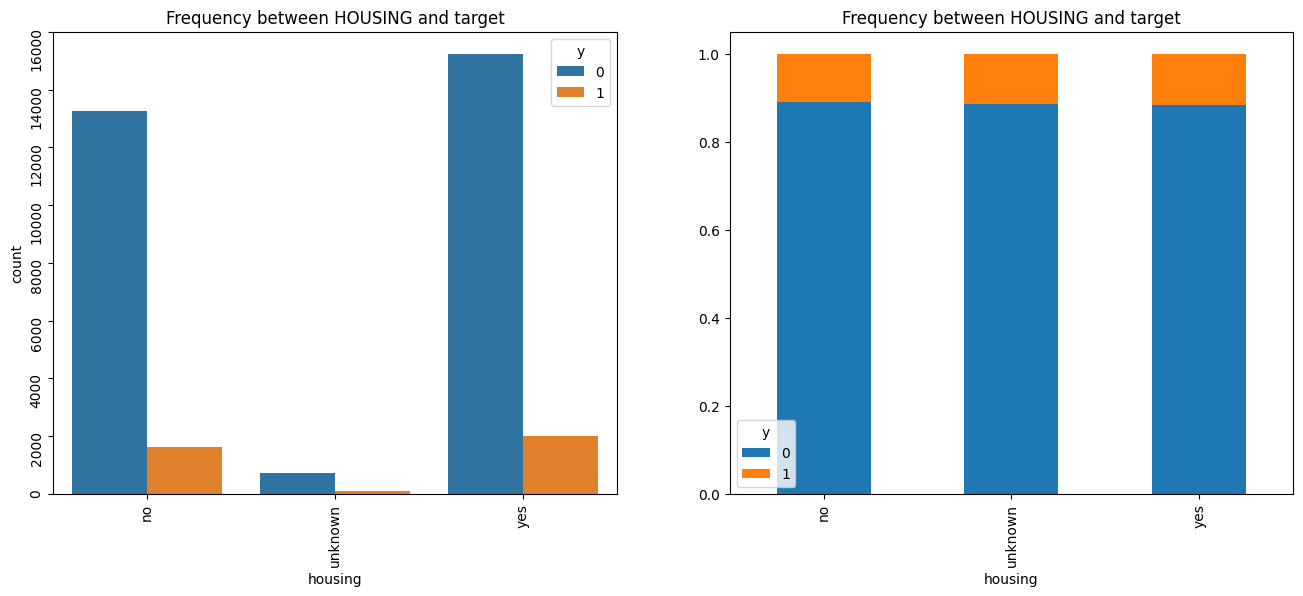

----------------------------------------------------------------------------------------------------


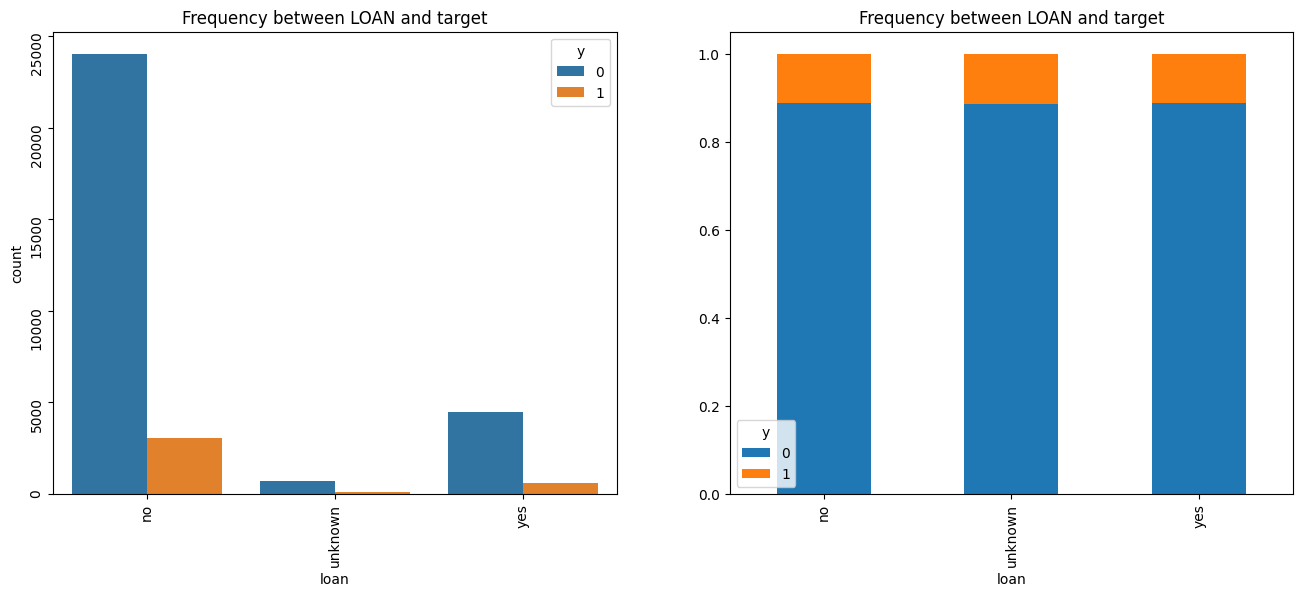

----------------------------------------------------------------------------------------------------


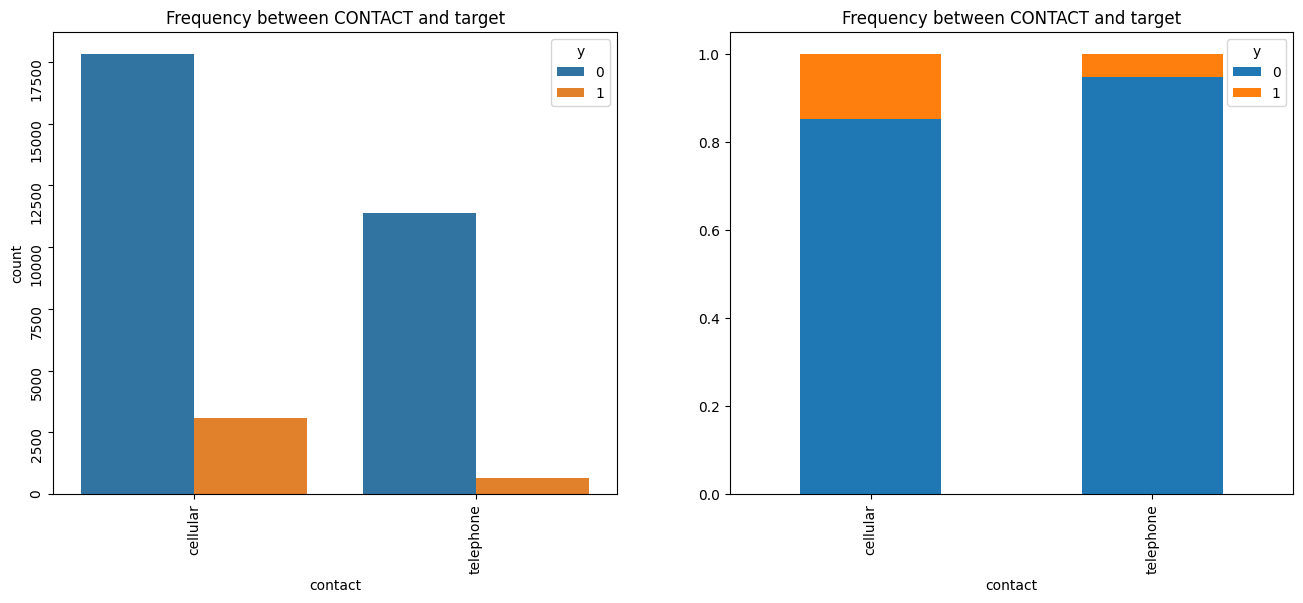

----------------------------------------------------------------------------------------------------


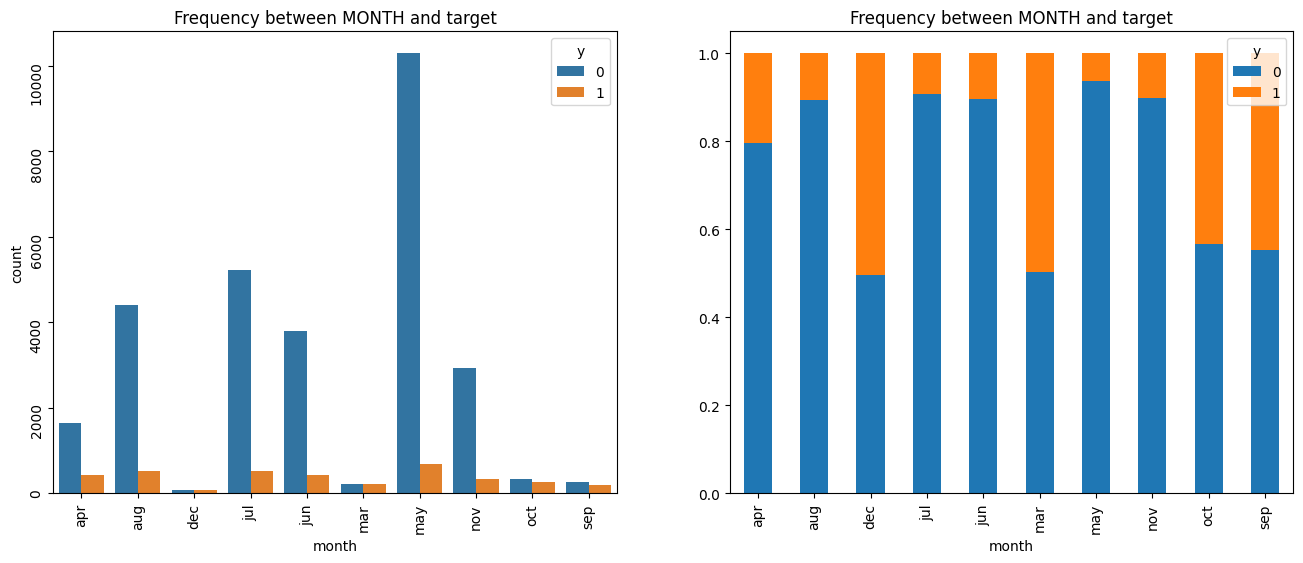

----------------------------------------------------------------------------------------------------


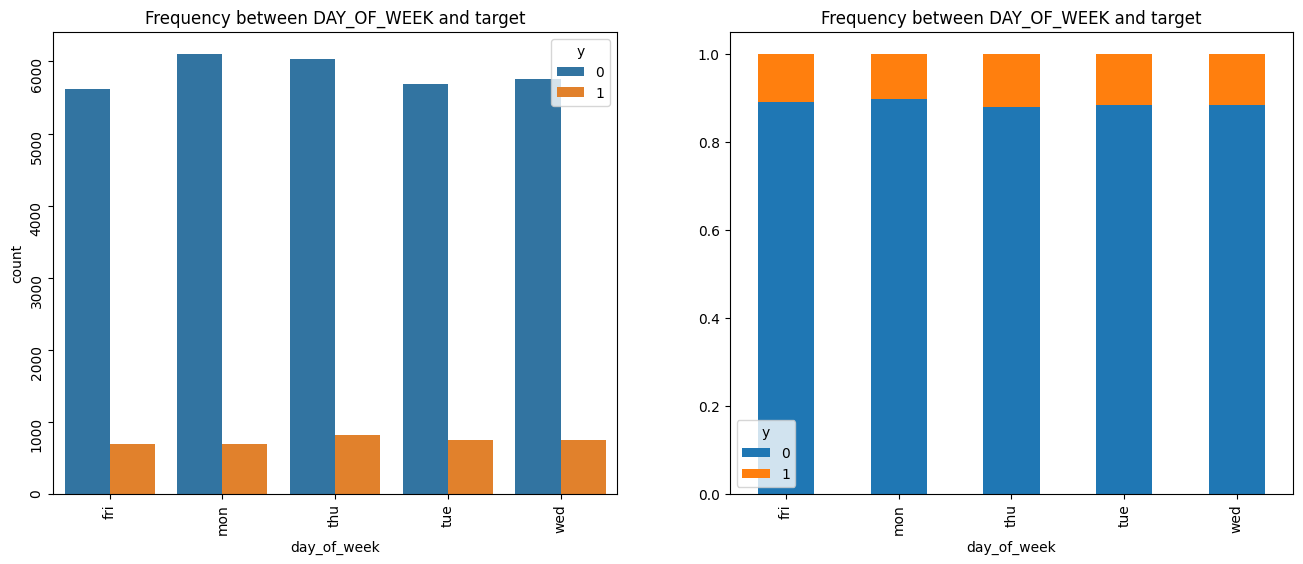

----------------------------------------------------------------------------------------------------


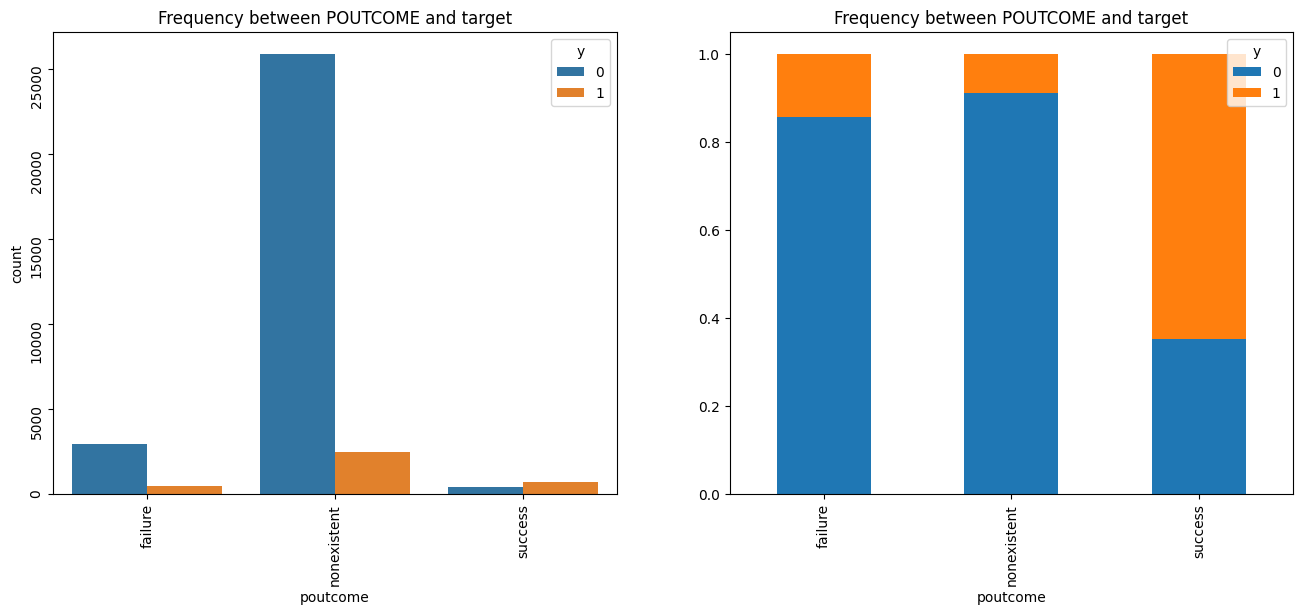

----------------------------------------------------------------------------------------------------


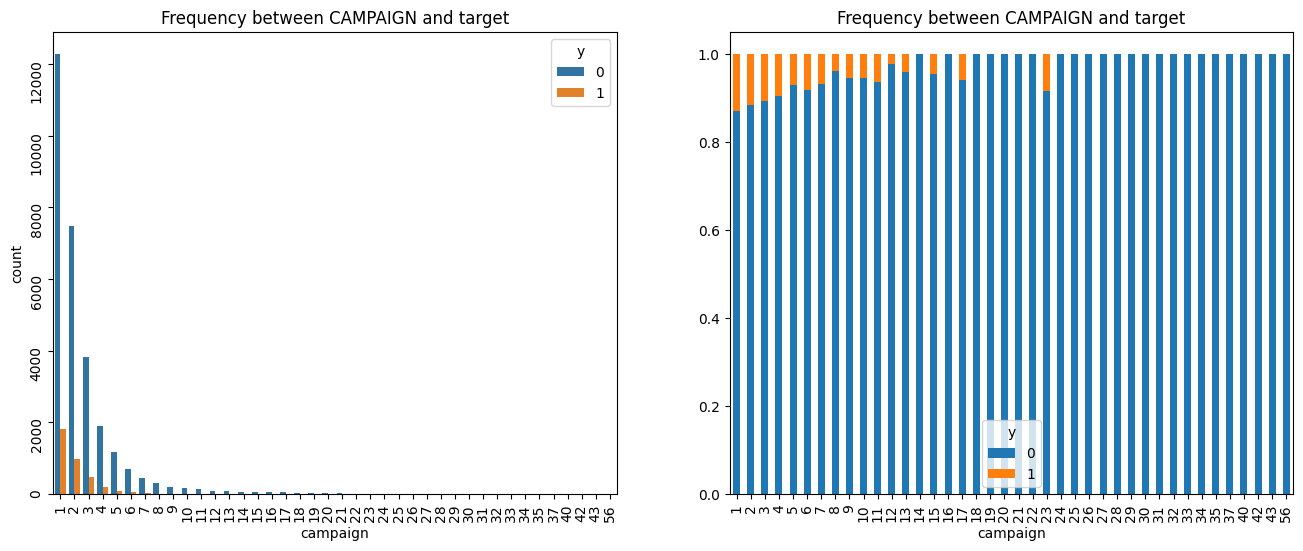

----------------------------------------------------------------------------------------------------


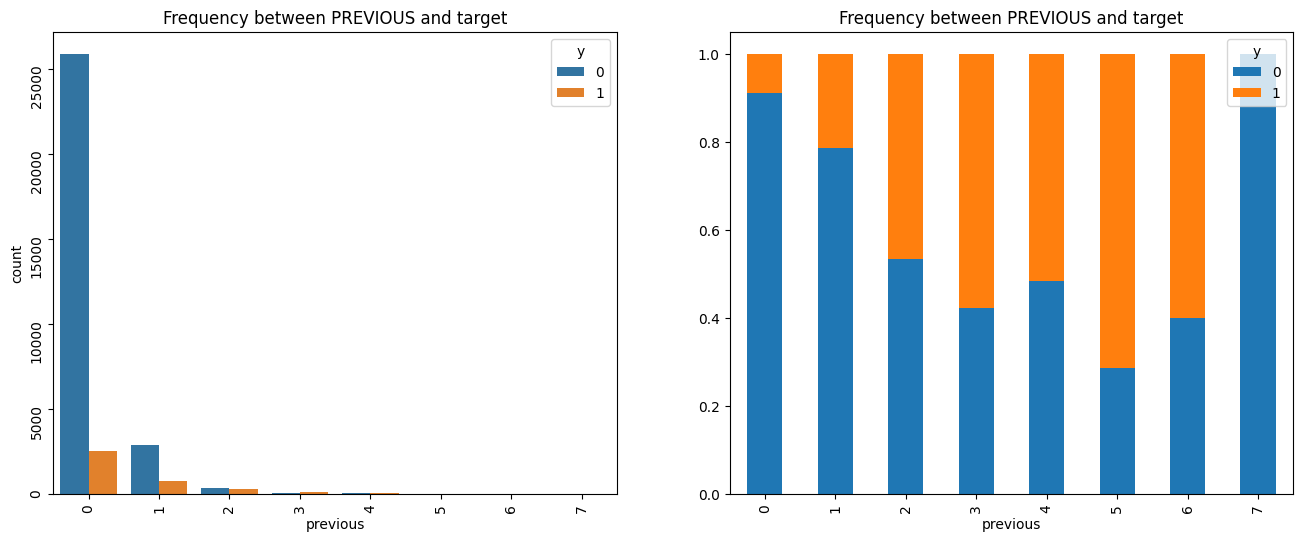

----------------------------------------------------------------------------------------------------


In [26]:
for cf in cat_feats:
    # display(df.groupby('job')['y'].agg(['count', 'median', 'mean', 'std']))
    df_freq = df.groupby([cf, "y"])[cf].count().reset_index(name="count")
    df_stack = df.groupby(cf)["y"].value_counts(normalize=True).unstack().fillna(0)

    figure, axis = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(data=df_freq, x=cf, hue="y", y="count", ax=axis[0])
    axis[0].tick_params(rotation=90)
    axis[0].set_title(f"Frequency between {cf.upper()} and target")

    df_stack.plot(
        kind="bar", stacked=True, color=["tab:blue", "tab:orange"], ax=axis[1]
    )
    axis[1].set_title(f"Frequency between {cf.upper()} and target")
    plt.show()

    print("-" * 100)

### basic preprocess

In [21]:
# education --> basics
df["education"] = df["education"].apply(lambda x: "basic" if "basic" in x else x)

# campaign --> drop low counted
campaign_to_drop = (
    df["campaign"].value_counts()[df["campaign"].value_counts() < 20].index
)
df.loc[df["campaign"].isin(campaign_to_drop), "campaign"] = 22

In [67]:
campaign_to_drop

Index([19, 22, 24, 23, 27, 25, 26, 31, 29, 28, 30, 35, 33, 43, 32, 42, 34, 37,
       40, 56],
      dtype='int64', name='campaign')

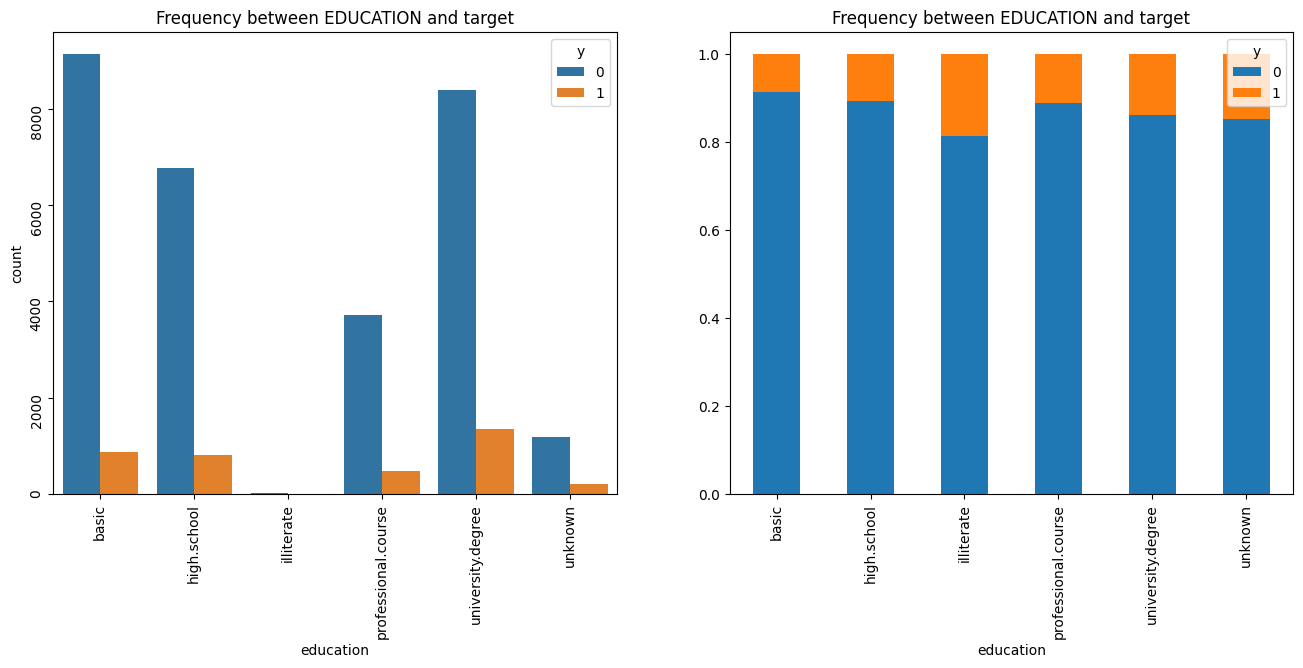

In [22]:
df_freq = df.groupby(["education", "y"])["education"].count().reset_index(name="count")
df_stack = df.groupby("education")["y"].value_counts(normalize=True).unstack().fillna(0)

figure, axis = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df_freq, x="education", hue="y", y="count", ax=axis[0])
axis[0].tick_params(rotation=90)
axis[0].set_title(f"Frequency between {'education'.upper()} and target")

df_stack.plot(kind="bar", stacked=True, color=["tab:blue", "tab:orange"], ax=axis[1])
axis[1].set_title(f"Frequency between {'education'.upper()} and target")
plt.show()

In [23]:
X = df.drop(["y", "age_bins", "duration_bins"], axis=1).copy()
y = df["y"].copy()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [25]:
X_train.shape, y_train.shape

((23037, 14), (23037,))

In [26]:
y_train.mean(), y_test.mean()

(0.11264487563484829, 0.11263040615820925)

### metics

In [27]:
from sklearn.metrics import (
    f1_score,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

In [28]:
# Try to maximize f2_score, because it seems than FN is more valuable then FP.
# We don't want to lose potential clients, we will get more calls (increase FP too).

In [29]:
def f2_score_custom(true, pred):
    pred_bin = (pred > 0.5).astype(int)
    return fbeta_score(true, pred_bin, beta=2)

In [30]:
def print_eval_metrics(true, pred, treshold=0.5):
    pred_bin = (pred > 0.5).astype(int)

    precision = precision_score(true, pred_bin)
    recall = recall_score(true, pred_bin)
    f1 = f1_score(true, pred_bin)
    f2 = f2_score_custom(true, pred)
    roc_auc = roc_auc_score(true, pred)

    print(f"precision {precision}")
    print(f"recall {recall}")
    print(f"f1 {f1}")
    print(f"f2 {f2}")
    print(f"roc_auc {roc_auc}")

In [31]:
def to_mean_eval_metrics(true, pred, treshold=0.5):
    pred_bin = (pred > 0.5).astype(int)

    precision = precision_score(true, pred_bin)
    recall = recall_score(true, pred_bin)
    f1 = f1_score(true, pred_bin)
    f2 = f2_score_custom(true, pred)
    roc_auc = roc_auc_score(true, pred)

    return [precision, recall, f1, f2, roc_auc]

### baseline

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [33]:
X = df.drop(["y", "age_bins", "duration_bins"], axis=1).copy()
y = df["y"].copy()

In [81]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
train_scores = []
test_scores = []
lr_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # emplty
    X_train_base = pd.DataFrame()
    X_test_base = pd.DataFrame()

    # ohe for cat feats
    for col in cat_feats:
        # fit
        enc = OneHotEncoder(handle_unknown="ignore")
        enc.fit(X_train[col].values.reshape(-1, 1))

        # columns
        names = [f"{col}-{x}" for x in enc.categories_[0]]

        # ...
        X_train_enc = pd.DataFrame(
            enc.transform(X_train[col].values.reshape(-1, 1)).toarray().astype(int),
            columns=names,
        )
        X_test_enc = pd.DataFrame(
            enc.transform(X_test[col].values.reshape(-1, 1)).toarray().astype(int),
            columns=names,
        )

        # to pandas

        X_train_base = pd.concat([X_train_base, X_train_enc], axis=1)
        X_test_base = pd.concat([X_test_base, X_test_enc], axis=1)

    # scaler int feats
    sc = StandardScaler()
    sc.fit(X_train[[x for x in X if x not in cat_feats]])

    X_train_sc = pd.DataFrame(
        sc.transform(X_train[[x for x in X if x not in cat_feats]]),
        columns=[x for x in X if x not in cat_feats],
    )
    X_test_sc = pd.DataFrame(
        sc.transform(X_test[[x for x in X if x not in cat_feats]]),
        columns=[x for x in X if x not in cat_feats],
    )

    X_train_base = pd.concat([X_train_base, X_train_sc], axis=1)
    X_test_base = pd.concat([X_test_base, X_test_sc], axis=1)

    # check
    print(X_train.shape, X_test.shape, X_train_base.shape, X_test_base.shape)

    # fit model
    lr = LogisticRegression(random_state=42, class_weight="balanced")
    lr.fit(X_train_base, y_train)
    lr_models.append(lr)

    # preds
    train_scores.append(
        to_mean_eval_metrics(y_train, lr.predict_proba(X_train_base)[:, 1])
    )
    test_scores.append(
        to_mean_eval_metrics(y_test, lr.predict_proba(X_test_base)[:, 1])
    )

(21940, 14) (10970, 14) (21940, 84) (10970, 84)
(21940, 14) (10970, 14) (21940, 84) (10970, 84)
(21940, 14) (10970, 14) (21940, 83) (10970, 83)


In [82]:
np.array(train_scores).mean(axis=0), np.array(test_scores).mean(axis=0)

(array([0.42186606, 0.82627481, 0.55854876, 0.6933373 , 0.9173685 ]),
 array([0.41972404, 0.82034271, 0.5553118 , 0.68883359, 0.91406164]))

#### drop useless features

In [83]:
from sklearn.feature_selection import RFE

In [84]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfe_train_scores = []
rfe_test_scores = []
rfe_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # emplty
    X_train_base = pd.DataFrame()
    X_test_base = pd.DataFrame()

    # ohe for cat feats
    for col in cat_feats:
        # fit
        enc = OneHotEncoder(handle_unknown="ignore")
        enc.fit(X_train[col].values.reshape(-1, 1))

        # columns
        names = [f"{col}-{x}" for x in enc.categories_[0]]

        # ...
        X_train_enc = pd.DataFrame(
            enc.transform(X_train[col].values.reshape(-1, 1)).toarray().astype(int),
            columns=names,
        )
        X_test_enc = pd.DataFrame(
            enc.transform(X_test[col].values.reshape(-1, 1)).toarray().astype(int),
            columns=names,
        )

        # to pandas

        X_train_base = pd.concat([X_train_base, X_train_enc], axis=1)
        X_test_base = pd.concat([X_test_base, X_test_enc], axis=1)

    # scaler int feats
    sc = StandardScaler()
    sc.fit(X_train[[x for x in X if x not in cat_feats]])

    X_train_sc = pd.DataFrame(
        sc.transform(X_train[[x for x in X if x not in cat_feats]]),
        columns=[x for x in X if x not in cat_feats],
    )
    X_test_sc = pd.DataFrame(
        sc.transform(X_test[[x for x in X if x not in cat_feats]]),
        columns=[x for x in X if x not in cat_feats],
    )

    X_train_base = pd.concat([X_train_base, X_train_sc], axis=1)
    X_test_base = pd.concat([X_test_base, X_test_sc], axis=1)

    # check
    print(X_train.shape, X_test.shape, X_train_base.shape, X_test_base.shape)

    # fit model
    lr_rfe = LogisticRegression(random_state=42, class_weight="balanced")
    rfe = RFE(lr_rfe, n_features_to_select=15)
    rfe.fit(X_train_base, y_train)
    rfe_models.append(lr)

    # preds
    rfe_train_scores.append(
        to_mean_eval_metrics(y_train, rfe.predict_proba(X_train_base)[:, 1])
    )
    rfe_test_scores.append(
        to_mean_eval_metrics(y_test, rfe.predict_proba(X_test_base)[:, 1])
    )

(21940, 14) (10970, 14) (21940, 84) (10970, 84)
(21940, 14) (10970, 14) (21940, 84) (10970, 84)
(21940, 14) (10970, 14) (21940, 83) (10970, 83)


In [85]:
np.array(rfe_train_scores).mean(axis=0), np.array(rfe_test_scores).mean(axis=0)

(array([0.41466783, 0.80455768, 0.54725408, 0.67718695, 0.91056004]),
 array([0.41356261, 0.79741581, 0.54462016, 0.67252656, 0.90893311]))

### other models, etc

In [34]:
df[cat_feats + ["age_bins", "duration_bins"]].apply((set)).apply(len)

job              12
marital           4
education         6
default           3
housing           3
loan              3
contact           2
month            10
day_of_week       5
poutcome          3
campaign         21
previous          8
age_bins         20
duration_bins    20
dtype: int64

In [92]:
X = df.drop("y", axis=1).copy()

#### JS encoding

In [96]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
enc_train_scores = []
enc_test_scores = []
enc_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # JS encoding
    jse = ce.JamesSteinEncoder(cols=cat_feats + ["age_bins", "duration_bins"])
    X_train_base = jse.fit_transform(X_train, y_train)
    X_test_base = jse.transform(X_test)

    # scaler int feats
    sc = StandardScaler()
    sc.fit(X_train[int_feats])

    X_train_base[int_feats] = sc.transform(X_train[int_feats])
    X_test_base[int_feats] = sc.transform(X_test[int_feats])

    # check
    print(X_train.shape, X_test.shape, X_train_base.shape, X_test_base.shape)

    # fit model
    lr_enc = LogisticRegression(random_state=42, class_weight="balanced")
    # rfe = RFE(lr_rfe, n_features_to_select=15)
    lr_enc.fit(X_train_base, y_train)
    enc_models.append(lr_enc)

    # preds
    enc_train_scores.append(
        to_mean_eval_metrics(y_train, lr_enc.predict_proba(X_train_base)[:, 1])
    )
    enc_test_scores.append(
        to_mean_eval_metrics(y_test, lr_enc.predict_proba(X_test_base)[:, 1])
    )

(21940, 16) (10970, 16) (21940, 16) (10970, 16)
(21940, 16) (10970, 16) (21940, 16) (10970, 16)
(21940, 16) (10970, 16) (21940, 16) (10970, 16)


In [97]:
np.array(enc_train_scores).mean(axis=0), np.array(enc_test_scores).mean(axis=0)

(array([0.42061815, 0.82087943, 0.55621953, 0.68962067, 0.91741249]),
 array([0.42041088, 0.81845315, 0.55548484, 0.68814363, 0.91608677]))

#### catboost

In [37]:
import optuna
from catboost import CatBoostClassifier, Pool, cv

In [38]:
X = df.drop("y", axis=1)
y = df["y"]

In [100]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,age_bins,duration_bins
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,"(47.0, 49.0]","(221.0, 248.0]"
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,"(35.0, 37.0]","(200.0, 221.0]"
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,"(58.0, 98.0]","(750.0, 4918.0]"
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,"(35.0, 37.0]","(117.0, 131.0]"
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,"(58.0, 98.0]","(319.0, 369.0]"


In [47]:
cv_dataset = Pool(
    data=X, label=y, cat_features=cat_feats + ["age_bins", "duration_bins"]
)

In [48]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500, step=100),
        "depth": trial.suggest_int("depth", 2, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "early_stopping_rounds": trial.suggest_int(
            "early_stopping_rounds", 10, 80, step=10
        ),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 0, 6),
        "loss_function": "Logloss",
        "eval_metric": "F:beta=2",
        "custom_metric": ["Precision", "Recall"],
        "auto_class_weights": "Balanced",
        "verbose": False,
    }

    cv_results = cv(
        cv_dataset,
        params,
        fold_count=3,
        stratified=True,
        partition_random_seed=42,
        verbose_eval=False,
        plot=True,
    )
    return cv_results["test-F:beta=2-mean"].iloc[-1]  # last value from iterations

In [49]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-02-13 19:23:12,469] A new study created in memory with name: no-name-a6ace8aa-0ee7-4327-9167-8263442e2a31


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8710749389
bestIteration = 271

Training on fold [1/3]

bestTest = 0.8479121374
bestIteration = 0

Training on fold [2/3]


[I 2025-02-13 19:23:30,657] Trial 0 finished with value: 0.8593562785938312 and parameters: {'iterations': 400, 'depth': 5, 'learning_rate': 0.027463471740173342, 'l2_leaf_reg': 0.3508310026260897, 'random_strength': 0.6607727427415515, 'bagging_temperature': 0.21270817590520907, 'early_stopping_rounds': 40, 'max_ctr_complexity': 3}. Best is trial 0 with value: 0.8593562785938312.



bestTest = 0.8828371749
bestIteration = 192



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8556858958
bestIteration = 112

Training on fold [1/3]

bestTest = 0.8510743191
bestIteration = 171

Training on fold [2/3]


[I 2025-02-13 19:23:38,290] Trial 1 finished with value: 0.8582478069523066 and parameters: {'iterations': 500, 'depth': 2, 'learning_rate': 0.20379173213711263, 'l2_leaf_reg': 0.3740938933282881, 'random_strength': 0.5351879129562194, 'bagging_temperature': 0.5988644821777989, 'early_stopping_rounds': 30, 'max_ctr_complexity': 0}. Best is trial 0 with value: 0.8593562785938312.



bestTest = 0.8740430333
bestIteration = 147



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8675595442
bestIteration = 78

Training on fold [1/3]

bestTest = 0.8567013535
bestIteration = 79

Training on fold [2/3]


[I 2025-02-13 19:23:47,662] Trial 2 finished with value: 0.8581313203924927 and parameters: {'iterations': 400, 'depth': 6, 'learning_rate': 0.16444731774460192, 'l2_leaf_reg': 0.09186210766122423, 'random_strength': 2.096848914911883, 'bagging_temperature': 0.3352239021006611, 'early_stopping_rounds': 50, 'max_ctr_complexity': 1}. Best is trial 0 with value: 0.8593562785938312.



bestTest = 0.8751663896
bestIteration = 92



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8668418203
bestIteration = 83

Training on fold [1/3]

bestTest = 0.8500188002
bestIteration = 77

Training on fold [2/3]


[I 2025-02-13 19:23:53,295] Trial 3 finished with value: 0.8640174423311703 and parameters: {'iterations': 500, 'depth': 3, 'learning_rate': 0.18290175065129213, 'l2_leaf_reg': 1.2527970790199587, 'random_strength': 0.10667173593633679, 'bagging_temperature': 0.6934230738081267, 'early_stopping_rounds': 20, 'max_ctr_complexity': 0}. Best is trial 3 with value: 0.8640174423311703.



bestTest = 0.8812291188
bestIteration = 105



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8679670092
bestIteration = 265

Training on fold [1/3]

bestTest = 0.8549017664
bestIteration = 164

Training on fold [2/3]


[I 2025-02-13 19:24:10,166] Trial 4 finished with value: 0.8667908760758536 and parameters: {'iterations': 400, 'depth': 3, 'learning_rate': 0.09370181641924995, 'l2_leaf_reg': 3.0644815628916553, 'random_strength': 1.1075009889719567, 'bagging_temperature': 0.7024352422227162, 'early_stopping_rounds': 50, 'max_ctr_complexity': 4}. Best is trial 4 with value: 0.8667908760758536.



bestTest = 0.8835512845
bestIteration = 208



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8483083673
bestIteration = 84

Training on fold [1/3]

bestTest = 0.8447851598
bestIteration = 60

Training on fold [2/3]


[I 2025-02-13 19:24:19,990] Trial 5 finished with value: 0.8444584110043317 and parameters: {'iterations': 300, 'depth': 5, 'learning_rate': 0.010211223389632616, 'l2_leaf_reg': 1.6710821623850414, 'random_strength': 0.5192749420070664, 'bagging_temperature': 0.2871973983974784, 'early_stopping_rounds': 60, 'max_ctr_complexity': 2}. Best is trial 4 with value: 0.8667908760758536.



bestTest = 0.8763211359
bestIteration = 0



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8357189323
bestIteration = 0

Training on fold [1/3]

bestTest = 0.8321014035
bestIteration = 0

Training on fold [2/3]


[I 2025-02-13 19:24:22,411] Trial 6 finished with value: 0.8254637746163681 and parameters: {'iterations': 200, 'depth': 2, 'learning_rate': 0.06091962094385702, 'l2_leaf_reg': 0.0010569263001856928, 'random_strength': 2.179976954717069, 'bagging_temperature': 0.8612706121178936, 'early_stopping_rounds': 40, 'max_ctr_complexity': 6}. Best is trial 4 with value: 0.8667908760758536.



bestTest = 0.8425511872
bestIteration = 0



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8716617112
bestIteration = 155

Training on fold [1/3]

bestTest = 0.862073171
bestIteration = 164

Training on fold [2/3]


[I 2025-02-13 19:24:39,440] Trial 7 finished with value: 0.871057851071035 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.11802558664890984, 'l2_leaf_reg': 1.0246046577492613, 'random_strength': 0.1506718035658148, 'bagging_temperature': 0.11019522240082313, 'early_stopping_rounds': 50, 'max_ctr_complexity': 3}. Best is trial 7 with value: 0.871057851071035.



bestTest = 0.8849790784
bestIteration = 83



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8144993525
bestIteration = 2

Training on fold [1/3]

bestTest = 0.8225391179
bestIteration = 1

Training on fold [2/3]


[I 2025-02-13 19:24:43,024] Trial 8 finished with value: 0.8119998786225824 and parameters: {'iterations': 100, 'depth': 6, 'learning_rate': 0.01043587737398853, 'l2_leaf_reg': 0.0031808741926649827, 'random_strength': 2.2631780177390697, 'bagging_temperature': 0.42885094069174134, 'early_stopping_rounds': 50, 'max_ctr_complexity': 0}. Best is trial 7 with value: 0.871057851071035.



bestTest = 0.8258664906
bestIteration = 1



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8357189323
bestIteration = 0

Training on fold [1/3]

bestTest = 0.806083953
bestIteration = 0

Training on fold [2/3]


[I 2025-02-13 19:24:46,213] Trial 9 finished with value: 0.7997409017830215 and parameters: {'iterations': 500, 'depth': 2, 'learning_rate': 0.013713864851972853, 'l2_leaf_reg': 4.3566589037127486, 'random_strength': 0.19650797071533177, 'bagging_temperature': 0.24645287129222615, 'early_stopping_rounds': 60, 'max_ctr_complexity': 4}. Best is trial 7 with value: 0.871057851071035.



bestTest = 0.8218867674
bestIteration = 7



In [50]:
best_params = study.best_trial.params
best_params["loss_function"] = "Logloss"
best_params["eval_metric"] = "F:beta=2"
best_params["custom_metric"] = ["Precision", "Recall"]
best_params["auto_class_weights"] = "Balanced"
best_params["cat_features"] = cat_feats + ["age_bins", "duration_bins"]
best_params["verbose"] = False
best_params

{'iterations': 300,
 'depth': 4,
 'learning_rate': 0.11802558664890984,
 'l2_leaf_reg': 1.0246046577492613,
 'random_strength': 0.1506718035658148,
 'bagging_temperature': 0.11019522240082313,
 'early_stopping_rounds': 50,
 'max_ctr_complexity': 3,
 'loss_function': 'Logloss',
 'eval_metric': 'F:beta=2',
 'custom_metric': ['Precision', 'Recall'],
 'auto_class_weights': 'Balanced',
 'cat_features': ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome',
  'campaign',
  'previous',
  'age_bins',
  'duration_bins'],
 'verbose': False}

In [51]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cat_train_scores = []
cat_test_scores = []
cat_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # fit
    cb_model = CatBoostClassifier(**best_params)
    cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)
    cat_models.append(cb_model)

    # preds
    cat_train_scores.append(
        to_mean_eval_metrics(y_train, cb_model.predict_proba(X_train)[:, 1])
    )
    cat_test_scores.append(
        to_mean_eval_metrics(y_test, cb_model.predict_proba(X_test)[:, 1])
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [52]:
np.array(cat_train_scores).mean(axis=0), np.array(cat_test_scores).mean(axis=0)

(array([0.42516172, 0.89020835, 0.57546144, 0.73039987, 0.93542618]),
 array([0.41816969, 0.88103455, 0.56709496, 0.72127295, 0.9289226 ]))

In [53]:
fi = pd.concat(
    [pd.DataFrame(cbm.feature_importances_, cbm.feature_names_) for cbm in cat_models]
).sort_values(0, ascending=False)

<Axes: xlabel='0', ylabel='None'>

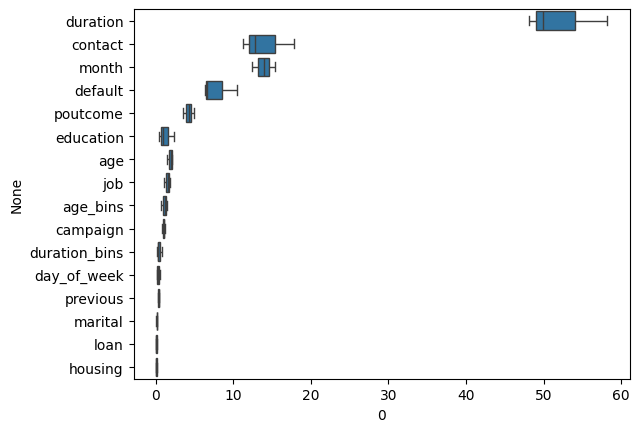

In [54]:
sns.boxplot(
    data=fi,
    x=0,
    y=fi.index,
    orient="h",
)

In [ ]:
# drop some feats

In [55]:
X = df.drop(["y", "day_of_week", "housing", "loan"], axis=1)
y = df["y"]

In [56]:
cv_dataset = Pool(
    data=X,
    label=y,
    cat_features=[
        x
        for x in cat_feats + ["age_bins", "duration_bins"]
        if x not in ["day_of_week", "housing", "loan"]
    ],
)

In [57]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500, step=100),
        "depth": trial.suggest_int("depth", 2, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "early_stopping_rounds": trial.suggest_int(
            "early_stopping_rounds", 10, 80, step=10
        ),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 0, 6),
        "loss_function": "Logloss",
        "eval_metric": "F:beta=2",
        "custom_metric": ["Precision", "Recall"],
        "auto_class_weights": "Balanced",
        "verbose": False,
    }

    cv_results = cv(
        cv_dataset,
        params,
        fold_count=3,
        stratified=True,
        partition_random_seed=42,
        verbose_eval=False,
        plot=True,
    )
    return cv_results["test-F:beta=2-mean"].iloc[-1]  # last value from iterations

In [58]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-02-13 19:25:40,211] A new study created in memory with name: no-name-30652717-492c-44b0-bdba-ccf57f104112


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8662477435
bestIteration = 98

Training on fold [1/3]

bestTest = 0.8537227442
bestIteration = 126

Training on fold [2/3]


[I 2025-02-13 19:25:47,085] Trial 0 finished with value: 0.8524637895798586 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.03799496080476792, 'l2_leaf_reg': 0.3140768951007529, 'random_strength': 0.17529937094661166, 'bagging_temperature': 0.1558575954260063, 'early_stopping_rounds': 20, 'max_ctr_complexity': 2}. Best is trial 0 with value: 0.8524637895798586.



bestTest = 0.849256609
bestIteration = 0



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8247748111
bestIteration = 4

Training on fold [1/3]

bestTest = 0.8264647106
bestIteration = 3

Training on fold [2/3]


[I 2025-02-13 19:25:54,494] Trial 1 finished with value: 0.8344502029741694 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.028028835175002, 'l2_leaf_reg': 6.877607235363808, 'random_strength': 3.94664549425595, 'bagging_temperature': 0.990544431735938, 'early_stopping_rounds': 60, 'max_ctr_complexity': 5}. Best is trial 0 with value: 0.8524637895798586.



bestTest = 0.8647967091
bestIteration = 144



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8729000868
bestIteration = 277

Training on fold [1/3]

bestTest = 0.8556424287
bestIteration = 179

Training on fold [2/3]


[I 2025-02-13 19:26:04,401] Trial 2 finished with value: 0.8670246300034119 and parameters: {'iterations': 300, 'depth': 2, 'learning_rate': 0.2342438541468104, 'l2_leaf_reg': 0.2657958362200348, 'random_strength': 0.3968489298658828, 'bagging_temperature': 0.29956897034343555, 'early_stopping_rounds': 40, 'max_ctr_complexity': 4}. Best is trial 2 with value: 0.8670246300034119.



bestTest = 0.8776733633
bestIteration = 98



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8335126284
bestIteration = 0

Training on fold [1/3]

bestTest = 0.832926584
bestIteration = 0

Training on fold [2/3]


[I 2025-02-13 19:26:05,175] Trial 3 finished with value: 0.782642494154589 and parameters: {'iterations': 100, 'depth': 6, 'learning_rate': 0.02657570137324464, 'l2_leaf_reg': 0.00440517901946353, 'random_strength': 3.911183870772159, 'bagging_temperature': 0.4559072854104955, 'early_stopping_rounds': 10, 'max_ctr_complexity': 0}. Best is trial 2 with value: 0.8670246300034119.



bestTest = 0.8438207327
bestIteration = 0



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8695521723
bestIteration = 119

Training on fold [1/3]

bestTest = 0.8590086797
bestIteration = 125

Training on fold [2/3]


[I 2025-02-13 19:26:16,409] Trial 4 finished with value: 0.8701739612498001 and parameters: {'iterations': 200, 'depth': 4, 'learning_rate': 0.05705892484780188, 'l2_leaf_reg': 1.0845487624802441, 'random_strength': 0.6373212277826953, 'bagging_temperature': 0.14378019381384644, 'early_stopping_rounds': 30, 'max_ctr_complexity': 2}. Best is trial 4 with value: 0.8701739612498001.



bestTest = 0.8840190914
bestIteration = 193



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8495581033
bestIteration = 1

Training on fold [1/3]

bestTest = 0.8450578336
bestIteration = 1

Training on fold [2/3]


[I 2025-02-13 19:26:19,811] Trial 5 finished with value: 0.8288243427368179 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.05969920927442656, 'l2_leaf_reg': 8.669191676945406, 'random_strength': 6.124789541469327, 'bagging_temperature': 0.8837851656598423, 'early_stopping_rounds': 60, 'max_ctr_complexity': 0}. Best is trial 4 with value: 0.8701739612498001.



bestTest = 0.8591845543
bestIteration = 0



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.858573562
bestIteration = 0

Training on fold [1/3]

bestTest = 0.8282403763
bestIteration = 0

Training on fold [2/3]


[I 2025-02-13 19:26:20,962] Trial 6 finished with value: 0.7979206190340099 and parameters: {'iterations': 500, 'depth': 3, 'learning_rate': 0.013400520050969839, 'l2_leaf_reg': 0.00597541655897631, 'random_strength': 5.178029144563829, 'bagging_temperature': 0.3004891904494179, 'early_stopping_rounds': 20, 'max_ctr_complexity': 0}. Best is trial 4 with value: 0.8701739612498001.



bestTest = 0.8408043941
bestIteration = 4



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.841392911
bestIteration = 391

Training on fold [1/3]

bestTest = 0.8508707534
bestIteration = 0

Training on fold [2/3]


[I 2025-02-13 19:26:35,474] Trial 7 finished with value: 0.8381692974443484 and parameters: {'iterations': 400, 'depth': 4, 'learning_rate': 0.026186849456342837, 'l2_leaf_reg': 0.004744864688737173, 'random_strength': 3.17719509466129, 'bagging_temperature': 0.3150900259501105, 'early_stopping_rounds': 60, 'max_ctr_complexity': 1}. Best is trial 4 with value: 0.8701739612498001.



bestTest = 0.8685875984
bestIteration = 398



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8701557396
bestIteration = 147

Training on fold [1/3]

bestTest = 0.8367186943
bestIteration = 12

Training on fold [2/3]


[I 2025-02-13 19:26:45,972] Trial 8 finished with value: 0.8569578726685961 and parameters: {'iterations': 200, 'depth': 5, 'learning_rate': 0.1281400425869535, 'l2_leaf_reg': 0.005524642107985806, 'random_strength': 5.226325582612769, 'bagging_temperature': 0.1407641119495785, 'early_stopping_rounds': 30, 'max_ctr_complexity': 6}. Best is trial 4 with value: 0.8701739612498001.



bestTest = 0.8790520211
bestIteration = 150



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8164217835
bestIteration = 43

Training on fold [1/3]

bestTest = 0.8321366834
bestIteration = 7

Training on fold [2/3]


[I 2025-02-13 19:26:48,907] Trial 9 finished with value: 0.7917969065365685 and parameters: {'iterations': 400, 'depth': 3, 'learning_rate': 0.019907656686792743, 'l2_leaf_reg': 0.0032571538491536632, 'random_strength': 5.913590227976372, 'bagging_temperature': 0.5059860201375335, 'early_stopping_rounds': 30, 'max_ctr_complexity': 6}. Best is trial 4 with value: 0.8701739612498001.



bestTest = 0.8242023475
bestIteration = 3



In [59]:
best_params = study.best_trial.params
best_params["loss_function"] = "Logloss"
best_params["eval_metric"] = "F:beta=2"
best_params["custom_metric"] = ["Precision", "Recall"]
best_params["auto_class_weights"] = "Balanced"
best_params["cat_features"] = [
    x
    for x in cat_feats + ["age_bins", "duration_bins"]
    if x not in ["day_of_week", "housing", "loan"]
]
best_params["verbose"] = False
best_params

{'iterations': 200,
 'depth': 4,
 'learning_rate': 0.05705892484780188,
 'l2_leaf_reg': 1.0845487624802441,
 'random_strength': 0.6373212277826953,
 'bagging_temperature': 0.14378019381384644,
 'early_stopping_rounds': 30,
 'max_ctr_complexity': 2,
 'loss_function': 'Logloss',
 'eval_metric': 'F:beta=2',
 'custom_metric': ['Precision', 'Recall'],
 'auto_class_weights': 'Balanced',
 'cat_features': ['job',
  'marital',
  'education',
  'default',
  'contact',
  'month',
  'poutcome',
  'campaign',
  'previous',
  'age_bins',
  'duration_bins'],
 'verbose': False}

In [60]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cat_train_scores = []
cat_test_scores = []
cat_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # fit
    cb_model = CatBoostClassifier(**best_params)
    cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)
    cat_models.append(cb_model)

    # preds
    cat_train_scores.append(
        to_mean_eval_metrics(y_train, cb_model.predict_proba(X_train)[:, 1])
    )
    cat_test_scores.append(
        to_mean_eval_metrics(y_test, cb_model.predict_proba(X_test)[:, 1])
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [61]:
np.array(cat_train_scores).mean(axis=0), np.array(cat_test_scores).mean(axis=0)

(array([0.41922582, 0.88575753, 0.56905997, 0.72445406, 0.93210913]),
 array([0.41619994, 0.8786078 , 0.5647471 , 0.71875565, 0.92789083]))

In [62]:
# (array([0.4222464 , 0.89209649, 0.573174  , 0.72968076, 0.93541683]),
#  array([0.41629277, 0.88049583, 0.56523751, 0.71984133, 0.92829628]))

In [63]:
fi = pd.concat(
    [pd.DataFrame(cbm.feature_importances_, cbm.feature_names_) for cbm in cat_models]
).sort_values(0, ascending=False)

<Axes: xlabel='0', ylabel='None'>

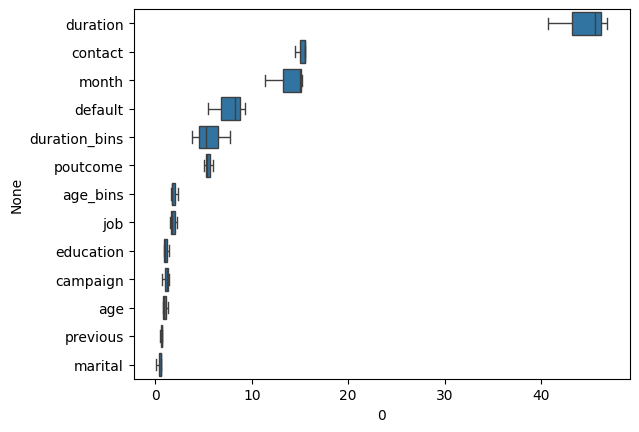

In [64]:
sns.boxplot(
    data=fi,
    x=0,
    y=fi.index,
    orient="h",
)